# Model evaluation using Sidekick

Use the Deployment API of the Peltarion platform via Sidekick to get predictions on samples and evaluate the performance of the deployed model in more detail.

Note: This notebook requires installation of Sidekick. For more information about this package, see:
https://github.com/Peltarion/sidekick

In [23]:
from glob import glob
import itertools
import os
import operator
import resource

from IPython.display import display, Image
import pandas as pd
from PIL import Image
from tqdm import tqdm
import sidekick
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Setup

### Paths

In [35]:
#preprocessed dataset
dataset_path = '/Users/joakim/rep/fruits/fruits-360/Test'
os.chdir(dataset_path)

### Client to deployment

In [60]:
#Update the URL and token

# Original
#deployment_url = 'https://a.peltarion.com/deployment/5f2a2f7a-cad0-44a8-8217-0ff9f0e4fd3e/forward'
#deployment_token = '8c0032e4-6204-4b23-ab14-90fc2a644408'

# Granny smith
deployment_url='https://a.peltarion.com/deployment/f2ccfa6c-4fb5-474a-a5cd-7a358654dfd8/forward'
deployment_token='5f629eb5-1c7b-4511-a0f8-c57a00678756'

client = sidekick.Deployment(
    url=deployment_url,
    token=deployment_token,
    dtypes_in={'image': 'Image (100x100x3)'},
    dtypes_out={'class': 'Categorical (103)'}
)

### Helper functions

In [61]:
def get_max_score(pred):
    max_key = 'None'
    max_score = 0
    dict = pred['class'].items()
    for key,score in dict:
        if score >= max_score:        
            max_key = key
            max_score = score
    return (max_key, max_score)


def get_image(path):
    im = Image.open(path)
    new_im = im.copy()
    new_im.format = 'jpeg'
    im.close()
    return new_im

### Progress bars for pandas

In [62]:
tqdm.pandas()

## Create test dataframe - ground truth

In [63]:
images_rel_path = glob(os.path.join('*', '*.jpg')) + glob(os.path.join('*', '*.png'))
print("Images found: ", len(images_rel_path))

Images found:  17845


In [64]:
df = pd.DataFrame({'image': images_rel_path})
df['class'] = df['image'].progress_apply(lambda path: os.path.basename(os.path.dirname(path)))
df = df.sample(frac=1).reset_index(drop=True)
df.head()

100%|██████████| 17845/17845 [00:00<00:00, 334307.13it/s]


,image,class
0,Mangostan/r_105_100.jpg,Mangostan
1,Cocos/r_181_100.jpg,Cocos
2,Apple Braeburn/r_326_100.jpg,Apple Braeburn
3,Huckleberry/r_220_100.jpg,Huckleberry
4,Apple Granny Smith/99_100.jpg,Apple Granny Smith


## Single  predictions

In [65]:
im_path_list = iter(list(df['image']))

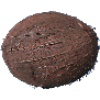

('Avocado ripe', 0.82096064)


In [67]:
im_path = next(im_path_list)
im = Image.open(im_path)
display(im)
pred = client.predict(image=im)
print(get_max_score(pred))

## Multiple predictions

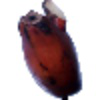

Ground truth: Banana Red
Prediction: Banana Red


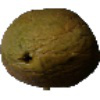

Ground truth: Papaya
Prediction: Papaya


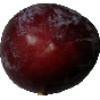

Ground truth: Plum
Prediction: Plum


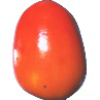

Ground truth: Kaki
Prediction: Kaki


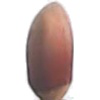

Ground truth: Hazelnut
Prediction: Hazelnut


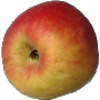

Ground truth: Apple Red Yellow 1
Prediction: Apple Red Yellow 1


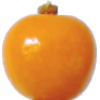

Ground truth: Physalis
Prediction: Physalis


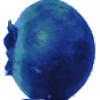

Ground truth: Huckleberry
Prediction: Huckleberry


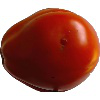

Ground truth: Tomato 1
Prediction: Tomato 1


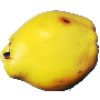

Ground truth: Quince
Prediction: Quince


In [68]:
rows = df.sample(n=10)
for i, row in rows.iterrows():
    im = Image.open(row['image'])    
    display(im)
    pred = client.predict(image=im)
    print('Ground truth: {}\nPrediction: {}'.format(row['class'], get_max_score(pred)[0]))

## Worst misclassified

Copy the image URLs to a new column.
Create a new column that contains the actual images.

In [69]:
eval_df = df.copy()
eval_df['image_url'] = eval_df['image']
eval_df['image'] = eval_df['image'].progress_apply(lambda path: get_image(path))
predictions = client.predict_lazy(eval_df.to_dict('record'))

100%|██████████| 17845/17845 [00:19<00:00, 922.13it/s]


Get all the predictions, this will take several minutes.
Store the predictions in a new column.

(This may take several minutes)

In [70]:
pbar = tqdm(total=len(eval_df))
preds = []
for p in predictions:
    preds.append(p)
    pbar.update(1)
pbar.close()

100%|██████████| 17845/17845 [33:03<00:00,  9.00it/s] 


In [71]:
#preds = [p for p in predictions]
eval_df['pred'] = [p['class'] for p in preds]
eval_df.head(5)

,image,class,image_url,pred
0,<PIL.Image.Image image mode=RGB size=100x100 a...,Mangostan,Mangostan/r_105_100.jpg,"{'Apple Granny Smith': 6.5139844e-26, 'Grapefr..."
1,<PIL.Image.Image image mode=RGB size=100x100 a...,Cocos,Cocos/r_181_100.jpg,"{'Apple Granny Smith': 2.4109821e-27, 'Grapefr..."
2,<PIL.Image.Image image mode=RGB size=100x100 a...,Apple Braeburn,Apple Braeburn/r_326_100.jpg,"{'Apple Granny Smith': 8.347966e-21, 'Grapefru..."
3,<PIL.Image.Image image mode=RGB size=100x100 a...,Huckleberry,Huckleberry/r_220_100.jpg,"{'Apple Granny Smith': 5.650851e-33, 'Grapefru..."
4,<PIL.Image.Image image mode=RGB size=100x100 a...,Apple Granny Smith,Apple Granny Smith/99_100.jpg,"{'Apple Granny Smith': 0.9999635, 'Grapefruit ..."


Create new columns that contain the name of highest scoring class and the score.

In [72]:
dicts = eval_df['pred']
max_keys = []
max_scores = []

for i in dicts:
    max_val = max(i.items(), key=lambda k: k[1])     
    max_keys.append(max_val[0])
    max_scores.append(max_val[1])
eval_df['pred_class'] = max_keys
eval_df['pred_score'] = max_scores
eval_df.head(5)

,image,class,image_url,pred,pred_class,pred_score
0,<PIL.Image.Image image mode=RGB size=100x100 a...,Mangostan,Mangostan/r_105_100.jpg,"{'Apple Granny Smith': 6.5139844e-26, 'Grapefr...",Mangostan,0.999926
1,<PIL.Image.Image image mode=RGB size=100x100 a...,Cocos,Cocos/r_181_100.jpg,"{'Apple Granny Smith': 2.4109821e-27, 'Grapefr...",Avocado ripe,0.820961
2,<PIL.Image.Image image mode=RGB size=100x100 a...,Apple Braeburn,Apple Braeburn/r_326_100.jpg,"{'Apple Granny Smith': 8.347966e-21, 'Grapefru...",Apple Braeburn,0.999962
3,<PIL.Image.Image image mode=RGB size=100x100 a...,Huckleberry,Huckleberry/r_220_100.jpg,"{'Apple Granny Smith': 5.650851e-33, 'Grapefru...",Huckleberry,1.000000
4,<PIL.Image.Image image mode=RGB size=100x100 a...,Apple Granny Smith,Apple Granny Smith/99_100.jpg,"{'Apple Granny Smith': 0.9999635, 'Grapefruit ...",Apple Granny Smith,0.999964


Get the top-ten samples with the highest prediction score and incorrect label.

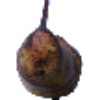

Ground truth: Pear Abate, Prediction: Granadilla, Score: 0.99999964


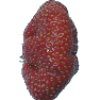

Ground truth: Strawberry Wedge, Prediction: Salak, Score: 0.9999957


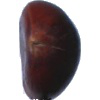

Ground truth: Chestnut, Prediction: Tomato 2, Score: 0.9999825


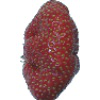

Ground truth: Strawberry Wedge, Prediction: Salak, Score: 0.99997866


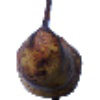

Ground truth: Pear Abate, Prediction: Granadilla, Score: 0.9999682


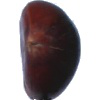

Ground truth: Chestnut, Prediction: Tomato 2, Score: 0.99994755


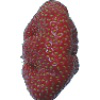

Ground truth: Strawberry Wedge, Prediction: Salak, Score: 0.99994147


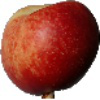

Ground truth: Nectarine, Prediction: Peach, Score: 0.9999378


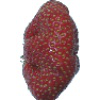

Ground truth: Strawberry Wedge, Prediction: Salak, Score: 0.9999294


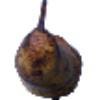

Ground truth: Pear Abate, Prediction: Granadilla, Score: 0.9999291


In [73]:
wrong_df = eval_df.loc[eval_df['class'] != eval_df['pred_class']]
wrong_df = wrong_df.sort_values(by=['pred_score'], ascending=False)
first_rows = wrong_df.head(10)
for i, row in first_rows.iterrows():
    display(row['image'])
    print('Ground truth: {}, Prediction: {}, Score: {}'.format(row['class'], row['pred_class'], row['pred_score']))

### Number of miclassified Apple Granny Smith

In [74]:
df_granny_smith = wrong_df.loc[df['class'] == 'Apple Granny Smith']
print(df_granny_smith.shape[0])

10


### View all misclassified samples in class Apple Granny Smith

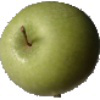

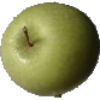

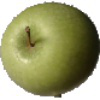

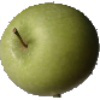

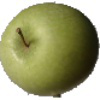

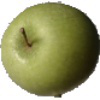

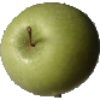

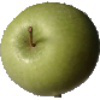

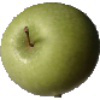

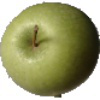

In [77]:
for i, row in df_granny_smith.iterrows():
    im = row['image']
    display(im)

## Classification report

In [76]:
print(classification_report(y_pred=eval_df['pred_class'], y_true=eval_df['class']))

                     precision    recall  f1-score   support

     Apple Braeburn       0.84      0.99      0.91       164
 Apple Crimson Snow       1.00      1.00      1.00       148
     Apple Golden 1       0.98      0.99      0.99       164
     Apple Golden 2       1.00      0.99      1.00       164
     Apple Golden 3       0.99      0.96      0.97       161
 Apple Granny Smith       1.00      0.94      0.97       164
    Apple Pink Lady       0.98      1.00      0.99       152
        Apple Red 1       1.00      1.00      1.00       164
        Apple Red 2       1.00      0.88      0.94       164
        Apple Red 3       1.00      0.78      0.88       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       1.00      1.00      1.00       164
 Apple Red Yellow 2       0.95      1.00      0.97       219
            Apricot       1.00      0.97      0.98       164
            Avocado       0.88      1.00      0.93       143
       Avocado ripe    

## Overall accuracy

In [78]:
1-wrong_df.shape[0]/df.shape[0]

0.9765200336228635